<a href="https://colab.research.google.com/github/Dylansppy/healthcare/blob/master/Lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This contains different methods for simplifying a model by removing some original features or transforming the data into fewer dimensions

#Classification metrics

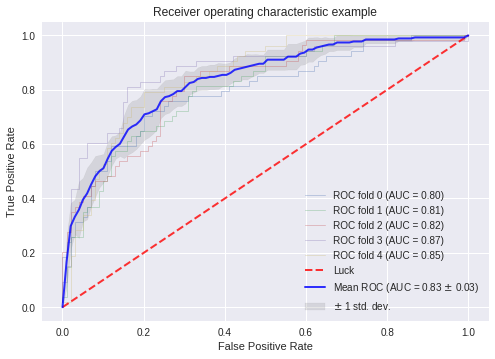

Mean ROC (AUC = 0.83077314 +- 0.02569488)


In [0]:
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn import metrics, neighbors, svm, calibration, tree, ensemble
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# pima indians diabetes set
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
feature_names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv(url, names=feature_names)
array = dataframe.values
data = array[:,0:8]
target = array[:,8]

# breast cancer
# cancer = load_breast_cancer()
# data = cancer.data
# target = cancer.target
# feature_names = cancer.feature_names

def test_model(model, X, y, show_plot=True):
  cv = StratifiedKFold(n_splits=5)

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0, 1, 100)

  i = 0
  for train, test in cv.split(X, y):
      probas_ = model.fit(X[train], y[train]).predict_proba(X[test])
      # Compute ROC curve and area the curve
      fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      tprs[-1][0] = 0.0
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      if show_plot:
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))


      i += 1

  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(mean_fpr, mean_tpr)
  std_auc = np.std(aucs)

  std_tpr = np.std(tprs, axis=0)
  tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
  tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

  if show_plot:
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
  
  print('Mean ROC (AUC = %0.8f +- %0.8f)' % (mean_auc, std_auc))

  
  

#test_model(svm.SVC(kernel='linear',probability=True), data, target)
#test_model(ensemble.RandomForestClassifier(), data, target)
test_model(LogisticRegression(), data, target)


#Univariate statistics for feature selection

In [0]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


for k in range(data.shape[1]):
  for scoref in [mutual_info_classif, chi2, f_classif]:
    X_new = SelectKBest(scoref, k=k+1).fit_transform(data, target)
    print('%s k=%s:' % (scoref.__name__, str(k+1)), end='')
    test_model(LogisticRegression(), X_new, target, False)





mutual_info_classif k=1:Mean ROC (AUC = 0.78868359 +- 0.02670290)
chi2 k=1:Mean ROC (AUC = 0.53881825 +- 0.04298396)
f_classif k=1:Mean ROC (AUC = 0.78868359 +- 0.02670290)
mutual_info_classif k=2:Mean ROC (AUC = 0.81227330 +- 0.02973971)
chi2 k=2:Mean ROC (AUC = 0.78822285 +- 0.02432910)
f_classif k=2:Mean ROC (AUC = 0.81227330 +- 0.02973971)
mutual_info_classif k=3:Mean ROC (AUC = 0.81945733 +- 0.02818060)
chi2 k=3:Mean ROC (AUC = 0.79967458 +- 0.02611988)
f_classif k=3:Mean ROC (AUC = 0.81945733 +- 0.02818060)
mutual_info_classif k=4:Mean ROC (AUC = 0.81907545 +- 0.02672676)
chi2 k=4:Mean ROC (AUC = 0.81907545 +- 0.02672676)
f_classif k=4:Mean ROC (AUC = 0.82275868 +- 0.02637391)
mutual_info_classif k=5:Mean ROC (AUC = 0.82235775 +- 0.02630551)
chi2 k=5:Mean ROC (AUC = 0.82235775 +- 0.02630551)
f_classif k=5:Mean ROC (AUC = 0.82950257 +- 0.02465243)
mutual_info_classif k=6:Mean ROC (AUC = 0.82868588 +- 0.02482947)
chi2 k=6:Mean ROC (AUC = 0.82204787 +- 0.02546520)
f_classif k=6:Mean

#Multivariate statistics for feature reduction/transformation to factors

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

for i in range(len(feature_names), 1, -1):
  #PCA is effected by scale so we scale the features to a unit vector
  data_scaled = StandardScaler().fit_transform(data)
  pca = PCA(n_components=i-1)
  principalComponents = pca.fit_transform(data_scaled)
  print("PCA %d " % (i-1), end='')
  test_model(LogisticRegression(), principalComponents, target, False)
  
#   cca = CCA(n_components=i-1)
#   cca.fit(data_scaled, target)
#   correlationComponents = cca.transform(data_scaled)
#   print(correlationComponents.shape)
#   print("CCA %d " % (i-1), end='')
#   test_model(LogisticRegression(), correlationComponents, target, False)
  

                   



PCA 8 Mean ROC (AUC = 0.83518977 +- 0.02358346)
(768, 8)
CCA 8 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 7 Mean ROC (AUC = 0.83439426 +- 0.02425123)
(768, 7)
CCA 7 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 6 Mean ROC (AUC = 0.83546647 +- 0.02554674)
(768, 6)
CCA 6 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 5 Mean ROC (AUC = 0.80600131 +- 0.01844756)
(768, 5)
CCA 5 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 4 Mean ROC (AUC = 0.79005499 +- 0.01765518)
(768, 4)
CCA 4 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 3 Mean ROC (AUC = 0.79205684 +- 0.01305837)
(768, 3)
CCA 3 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 2 Mean ROC (AUC = 0.76589515 +- 0.01537867)
(768, 2)
CCA 2 Mean ROC (AUC = 0.84256824 +- 0.02150756)
PCA 1 Mean ROC (AUC = 0.73425944 +- 0.02403205)
(768, 1)
CCA 1 Mean ROC (AUC = 0.84256824 +- 0.02150756)


/usr/local/lib/python3.6/dist-packages/sklearn/cross_decomposition/pls_.py:287: UserWarning: Y residual constant at iteration 1
  warnings.warn('Y residual constant at iteration %s' % k)


#Model based feature selection

In [0]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=LogisticRegression(), n_features_to_select=1, step=1)
rfe.fit(data, target)
print(rfe.ranking_)

print(feature_names)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), feature_names)))

for i in range(len(feature_names)-1, 1, -1):
  # use the rfe order to select features and then test it
  rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i-1, step=1)
  rfe.fit(data, target)
  selected = [name for rank, name in zip(map(lambda x: round(x, 4), rfe.ranking_), feature_names) if rank == 1]
  subset = dataframe[selected]
  print(selected,end='')
  test_model(LogisticRegression(), subset.values, target, False)




[2 4 5 7 8 3 1 6]
['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
[(1, 'pedi'), (2, 'preg'), (3, 'mass'), (4, 'plas'), (5, 'pres'), (6, 'age'), (7, 'skin'), (8, 'test')]
['preg', 'plas', 'pres', 'skin', 'mass', 'pedi', 'age']Mean ROC (AUC = 0.83118255 +- 0.02511300)
['preg', 'plas', 'pres', 'mass', 'pedi', 'age']Mean ROC (AUC = 0.83148678 +- 0.02529399)
['preg', 'plas', 'pres', 'mass', 'pedi']Mean ROC (AUC = 0.83376391 +- 0.02371365)
['preg', 'plas', 'mass', 'pedi']Mean ROC (AUC = 0.83298887 +- 0.02198142)
['preg', 'mass', 'pedi']Mean ROC (AUC = 0.73399332 +- 0.02640411)
['preg', 'pedi']Mean ROC (AUC = 0.66407478 +- 0.04112661)
['pedi']Mean ROC (AUC = 0.60764107 +- 0.06072214)


#Pipeline

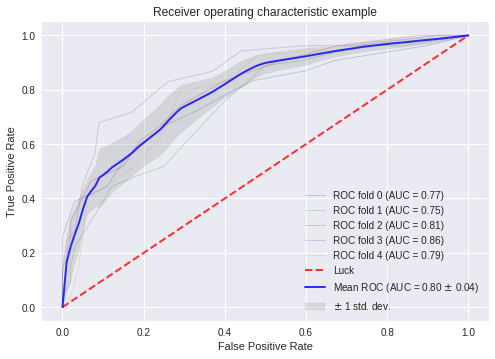

Mean ROC (AUC = 0.79635079 +- 0.03832333)


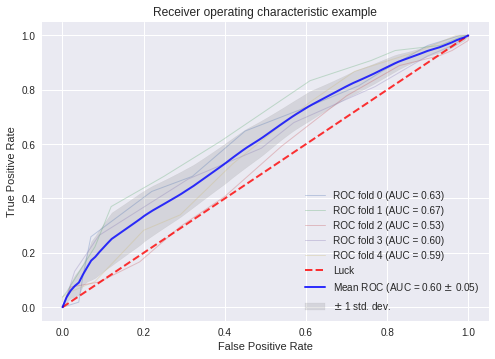

Mean ROC (AUC = 0.60248570 +- 0.04833828)


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

test_model(neighbors.KNeighborsClassifier(n_neighbors=16), data, target)

clf = Pipeline([
  ('feature_selection', SelectFromModel(LogisticRegression())),
  ('classification', neighbors.KNeighborsClassifier(n_neighbors=16))
])
test_model(clf, data, target)
#clf.fit(data, target)